<a href="https://colab.research.google.com/github/HagaiHen/NewSpaceEx1/blob/main/New_Space_Ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive' , force_remount=True)


#enter your foldername assignments/assignement1
FOLDERNAME = 'Vision'
              
assert FOLDERNAME is not None , "[!] Enter the foldername"

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [2]:
from pyparsing.helpers import alphanums
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import random
import math

In [3]:
# RANSAC

def draw_line(image, m, b, color=(255, 255, 255), thickness=2):
    """Draws a line on an image given a slope and y-intercept."""
    h, w = image.shape[:2]
    
    # Compute the starting and ending points of the line
    x1 = 0
    y1 = int(b)
    x2 = w - 1
    y2 = int(m * x2 + b)
    
    # Draw the line on the image
    cv.line(image, (x1, y1), (x2, y2), color, thickness)
    
    return image

def sort_top_three(lst, points_on_line, line, count):
    candidate = points_on_line, count, line
    if candidate not in lst:
      if lst[0][1] < count:
        lst[0]=candidate
      elif lst[1][1] < count:
        lst[1]=candidate
      elif lst[2][1] < count:
        lst[2]=candidate
      else:
        return lst
    return lst

def ransac_line_fit(points, threshold=20, max_iterations=5000):
    best_fit = None
    best_count = 0
    points_on_line = []
    ans=[]
    top_three = [[(0,0),0],[(0,0),0],[(0,0),0]]
    for i in range(max_iterations):
        # Randomly select two points from the set
        sample = random.sample(points, 2)
        curr_points = []
        # Fit a line to the selected points
        x1, y1, r, b = sample[0]
        x2, y2, r, b = sample[1]
        if x1 == x2:
            continue  # avoid division by zero
        m = (y2 - y1) / (x2 - x1)
        b = y1 - m * x1
        
        # Count the number of inliers
        count = 0
        for x, y, r, c in points:
            if abs(y - (m * x + b)) < threshold:
                count += 1
                curr_points.append([x,y,r,c])
        # Update the best-fit line if we found more inliers than before
        top_three = sort_top_three(top_three, curr_points, (m, b), count)
        if count > best_count and count >= 3:
            best_fit = (m, b)
            best_count = count
            points_on_line = curr_points
            ans.insert(0, best_fit)
    
    return best_fit, points_on_line, top_three

In [4]:
# Detection

def stars_detection(img):
    tmp_min = 0
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Apply a threshold to create a binary image
    ret, thresh = cv.threshold(img, 160, 255, cv.THRESH_BINARY)

    # Find contours in the binary image
    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    # Loop through the contours and find the centers of the stars
    centers = []
    for cnt in contours:
        # Calculate the bounding box of the contour
        x,y,w,h = cv.boundingRect(cnt)

        # Check if the bounding box is too close to any of the previous centers
        too_close = False
        for center in centers:
            if abs(center[0]-x) < 50 and abs(center[1]-y) < 50:
                too_close = True
                break
        if not too_close and w < 100 and h < 100:
            # Calculate the center of the star
            center_x = x + w // 2
            center_y = y + h // 2
            brightness = img[center_y, center_x]
            centers.append((x, y, min(w, h), brightness))
                        
    return centers

def initial_detection(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Apply a threshold to create a binary image
    ret, thresh = cv.threshold(img, 140, 255, cv.THRESH_BINARY)

    # Apply morphological operations
    kernel = np.ones((6,6), np.uint8)
    opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel)

    # Find contours
    contours, hierarchy = cv.findContours(opening, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    # Loop through the contours and find the centers of the stars
    centers = []
    for cnt in contours:
        # Calculate the minimum enclosing circle of the contour
        (center_x, center_y), radius = cv.minEnclosingCircle(cnt)

        # Check if the center is too close to any of the previous centers
        too_close = False
        for center in centers:
            if abs(center[0]-center_x) < 50 and abs(center[1]-center_y) < 50:
                too_close = True
                break
        if not too_close:
            # Get the brightness value of the center pixel
            brightness = img[int(center_y), int(center_x)]

            # Add the center to the list
            centers.append((int(center_x), int(center_y), int(radius), brightness))
            
    return centers

def draw_rectangles(img, rectangles, color):
    for rect in rectangles:
      cv.rectangle(img, (rect[0]-40,rect[1]-40), (rect[0]+rect[2]+40,rect[1]+rect[2]+40), color, 7)


In [5]:
# Find matching

def draw_rectangles_manually(img, rectangles):
    for rect in rectangles:
          cv.rectangle(img, (rect[0]-40,rect[1]-40), (rect[0]+rect[2]+40,rect[1]+rect[2]+40), (0,0,0), 7)

def similarity(line_points1, line_points2):
    AB = distance(line_points2[0], line_points2[1])
    BC = distance(line_points2[1], line_points2[2])
    AC = distance(line_points2[2], line_points2[0])
    min_diff = 50000
    same_points = []
    for i in range(len(line_points1)-2):
      curr_points = []
      DE = distance(line_points1[i], line_points1[i+1])
      EF = distance(line_points1[i+1], line_points1[i+2])
      FD = distance(line_points1[i+2], line_points1[i])
      curr_points.append(line_points1[i])
      curr_points.append(line_points1[i+1])
      curr_points.append(line_points1[i+2])
      curr_diff = abs(abs(AB/DE-BC/EF) + abs(BC/EF-AC/FD) + abs(AB/DE-AC/FD))
      if curr_diff < min_diff:
        min_diff = curr_diff
        same_points = curr_points
    for point in same_points:
      point = tuple(point)

    return min_diff, same_points

def distance(point1, point2):
  x1, y1, r1, b1 = point1
  x2, y2, r2, b2 = point2
  return math.sqrt((x2-x1)**2+(y2-y1)**2)

In [6]:
# Transformation and Translation

def compute_transformation(best_correlation):
  x1_1, y1_1, r1_1, b1_1 = best_correlation[0][0]
  x1_2, y1_2, r1_2, b1_2 = best_correlation[0][1]
  x1_3, y1_3, r1_3, b1_3 = best_correlation[0][2]
  x2_1, y2_1, r2_1, b2_1 = best_correlation[1][0]
  x2_2, y2_2, r2_2, b2_2 = best_correlation[1][1]
  x2_3, y2_3, r2_3, b2_3 = best_correlation[1][2]

  # Define the points in img1 and img2 as numpy arrays
  img1_points = np.array([[x1_1, y1_1], [x1_2, y1_2], [x1_3, y1_3]])
  img2_points = np.array([[x2_1, y2_1], [x2_2, y2_2], [x2_3, y2_3]])

  # Compute the difference vectors
  v1 = img1_points[1] - img1_points[0]
  v2 = img2_points[1] - img2_points[0]

  # Compute the scaling factor
  s = np.linalg.norm(v2) / np.linalg.norm(v1)

  # Compute the rotation matrix
  v1_unit = v1 / np.linalg.norm(v1)
  v2_unit = v2 / np.linalg.norm(v2)
  cos_theta = np.dot(v1_unit, v2_unit)
  sin_theta = np.cross(v1_unit, v2_unit)
  R = np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]])

  # Compute the translation vector
  t = img2_points[0] - s * R.dot(img1_points[0])

  return s,R, t

# Define the transformation function
def transform(x1, y1, s, R, t):
    p = np.array([x1, y1])
    p_transformed = s * R.dot(p) + t
    return p_transformed[0], p_transformed[1]

In [7]:
# # Main

# # Load the image
# img1 = cv.imread('/content/drive/MyDrive/Vision/fr1.jpg')
# img2 = cv.imread('/content/drive/MyDrive/Vision/ST_db1.png')
# img3 = cv.imread('/content/drive/MyDrive/Vision/fr2.jpg')
# img4 = cv.imread('/content/drive/MyDrive/Vision/ST_db2.png')

# images = [img1, img2, img3, img4]

# for i in range(len(images)-1):
#   original_img = images[i]
#   img1 = original_img
#   for j in range(i+1, len(images)):
#     img2 = images[j]

#     rect1 = initial_detection(img1)
#     rect2 = initial_detection(img2)

#     # Keep img1 to be the small one
#     if (len(rect1) > len(rect2)):
#       tmp = img1
#       img1 = img2
#       img2 = tmp
#       tmp = rect1
#       rect1 = rect2
#       rect2 = tmp

#     # Find the lines using RANSAC
#     lines1, line_points1, top_three1 = ransac_line_fit(rect1)
#     lines2, line_points2, top_three2 = ransac_line_fit(rect2)

#     best_diff = 2
#     for three_points1, c1, (m1, b1) in top_three1:
#       for three_points2, c2, (m2, b2) in top_three2:
#         curr_diff = similarity(three_points1, three_points2)[0]
#         if curr_diff < best_diff:
#           best_diff = curr_diff
#           best_line = ((m1, b1), (m2, b2))
#           best_correlation = (three_points1[:3], three_points2[:3])

#     m1, b1 = best_line[0]
#     m2, b2 = best_line[1]

#     img1 = draw_line(img1, m1, b1)
#     img2 = draw_line(img2, m2, b2)

#     s, R, t = compute_transformation(best_correlation)

#     new_list = []

#     # Detection

#     s_points = stars_detection(img1)


#     draw_rectangles(img1, s_points, (0,0,0))

#     for x, y, r, b in s_points:
#       newx, newy = transform(x,y, s, R, t)
#       new_list.append((int(newx), int(newy), r, b))

#     myList = []
#     for point in new_list:
#       curr_point = []
#       _min = 50000
#       for og_point in rect1:
#         if distance(point, og_point) < _min:
#           curr_point = og_point
#       myList.append(curr_point)

#     draw_rectangles_manually(img2, new_list)

#     plt.imshow(img1), plt.show()
#     plt.imshow(img2), plt.show()

#     print("######## Correlation ########")
#     for i in range(len(new_list)):
#       print(f"{new_list[i]}, {s_points[i]}")
    
#     print("\n\n\n\n############################################################################################")
#     img1 = original_img

# Exampels:

**fr1.jpg, ST_db1.png**

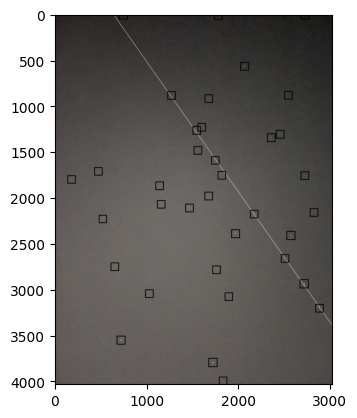

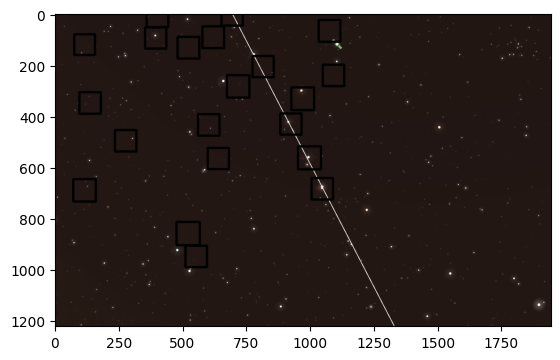

######## Correlation ########
(1826, 3996, 4, 215) => (550, 947, 4, 215)
(1712, 3792, 11, 252) => (515, 854, 11, 252)
(714, 3550, 8, 254) => (111, 686, 8, 254)
(2874, 3204, 4, 176) => (1043, 682, 4, 176)
(1889, 3078, 3, 181) => (637, 564, 3, 181)
(1024, 3045, 4, 168) => (274, 494, 4, 168)
(2705, 2935, 10, 243) => (990, 558, 10, 243)
(1754, 2785, 4, 242) => (599, 432, 4, 242)
(648, 2752, 4, 212) => (135, 346, 4, 212)
(2561, 2409, 9, 247) => (964, 327, 9, 247)
(1960, 2390, 8, 254) => (712, 279, 8, 254)
(519, 2233, 1, 164) => (115, 119, 1, 164)
(2815, 2160, 4, 219) => (1087, 238, 4, 219)
(1460, 2111, 5, 251) => (519, 129, 5, 251)
(1153, 2072, 3, 168) => (392, 92, 3, 168)
(1669, 1981, 5, 250) => (616, 88, 5, 250)
(1135, 1869, 5, 239) => (398, 6, 5, 239)
(178, 1801, 3, 203) => (0, -85, 3, 203)
(2715, 1759, 5, 224) => (1071, 63, 5, 224)
(1812, 1756, 3, 182) => (691, 2, 3, 182)
(470, 1713, 3, 172) => (128, -103, 3, 172)
(1742, 1594, 2, 168) => (672, -70, 2, 168)
(1552, 1484, 4, 189) => (599, 

In [8]:
# Load the image
img1 = cv.imread('/content/drive/MyDrive/Vision/fr1.jpg')
img2 = cv.imread('/content/drive/MyDrive/Vision/ST_db1.png')

orig_img1 = img1
orig_img2 = img2

rect1 = initial_detection(img1)
rect2 = initial_detection(img2)

# Keep img1 to be the small one
if (len(rect1) > len(rect2)):
  tmp = img1
  img1 = img2
  img2 = tmp
  tmp = rect1
  rect1 = rect2
  rect2 = tmp

# Find the lines using RANSAC
lines1, line_points1, top_three1 = ransac_line_fit(rect1)
lines2, line_points2, top_three2 = ransac_line_fit(rect2)

best_diff = 2
for three_points1, c1, (m1, b1) in top_three1:
  for three_points2, c2, (m2, b2) in top_three2:
    curr_diff = similarity(three_points1, three_points2)[0]
    if curr_diff < best_diff:
      best_diff = curr_diff
      best_line = ((m1, b1), (m2, b2))
      best_correlation = (three_points1[:3], three_points2[:3])

m1, b1 = best_line[0]
m2, b2 = best_line[1]

img1 = draw_line(img1, m1, b1)
img2 = draw_line(img2, m2, b2)

s, R, t = compute_transformation(best_correlation)

transformed_points = []

# Detection
img1 = orig_img1
img2 = orig_img2

s_points = stars_detection(img1)
draw_rectangles(img1, s_points, (0,0,0))

for x, y, r, b in s_points:
  newx, newy = transform(x,y, s, R, t)
  transformed_points.append((int(newx), int(newy), r, b))

draw_rectangles_manually(img2, transformed_points)

plt.imshow(img1), plt.show()
plt.imshow(img2), plt.show()

print("######## Correlation ########")
for i in range(len(transformed_points)):
  print(f"{s_points[i]} => {transformed_points[i]}")

**fr1.jpg, ST_db2.png**

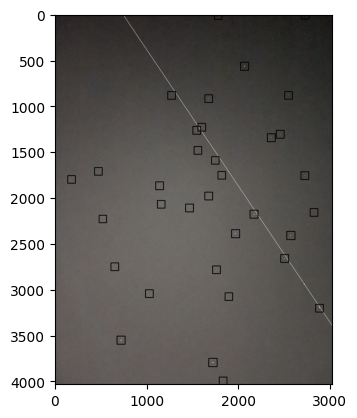

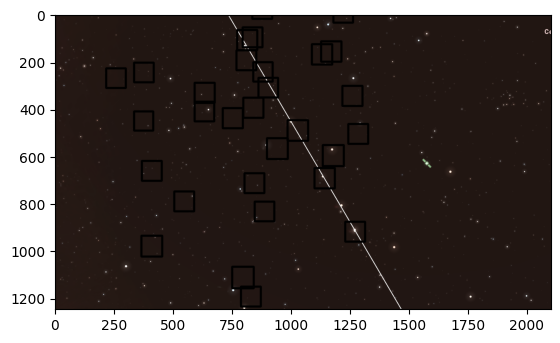

######## Correlation ########
(1826, 3996, 4, 215) => (826, 1191, 4, 215)
(1712, 3792, 11, 252) => (789, 1107, 11, 252)
(714, 3550, 8, 254) => (405, 976, 8, 254)
(2874, 3204, 4, 176) => (1267, 917, 4, 176)
(1889, 3078, 3, 181) => (884, 832, 3, 181)
(1024, 3045, 4, 168) => (544, 789, 4, 168)
(1754, 2785, 4, 242) => (841, 712, 4, 242)
(648, 2752, 4, 212) => (407, 660, 4, 212)
(2495, 2661, 6, 238) => (1137, 690, 6, 238)
(2561, 2409, 9, 247) => (1172, 593, 9, 247)
(1960, 2390, 8, 254) => (936, 564, 8, 254)
(519, 2233, 1, 164) => (374, 451, 1, 164)
(2161, 2178, 7, 239) => (1023, 488, 7, 239)
(2815, 2160, 4, 219) => (1280, 504, 4, 219)
(1460, 2111, 5, 251) => (749, 437, 5, 251)
(1153, 2072, 3, 168) => (630, 410, 3, 168)
(1669, 1981, 5, 250) => (836, 393, 5, 250)
(1135, 1869, 5, 239) => (630, 330, 5, 239)
(178, 1801, 3, 203) => (256, 269, 3, 203)
(2715, 1759, 5, 224) => (1255, 343, 5, 224)
(1812, 1756, 3, 182) => (900, 309, 3, 182)
(470, 1713, 3, 172) => (374, 245, 3, 172)
(1742, 1594, 2, 168

In [9]:
# Load the image
img1 = cv.imread('/content/drive/MyDrive/Vision/fr1.jpg')
img2 = cv.imread('/content/drive/MyDrive/Vision/ST_db2.png')

orig_img1 = img1
orig_img2 = img2

rect1 = initial_detection(img1)
rect2 = initial_detection(img2)

# Keep img1 to be the small one
if (len(rect1) > len(rect2)):
  tmp = img1
  img1 = img2
  img2 = tmp
  tmp = rect1
  rect1 = rect2
  rect2 = tmp

# Find the lines using RANSAC
lines1, line_points1, top_three1 = ransac_line_fit(rect1)
lines2, line_points2, top_three2 = ransac_line_fit(rect2)

best_diff = 2
for three_points1, c1, (m1, b1) in top_three1:
  for three_points2, c2, (m2, b2) in top_three2:
    curr_diff = similarity(three_points1, three_points2)[0]
    if curr_diff < best_diff:
      best_diff = curr_diff
      best_line = ((m1, b1), (m2, b2))
      best_correlation = (three_points1[:3], three_points2[:3])

m1, b1 = best_line[0]
m2, b2 = best_line[1]

img1 = draw_line(img1, m1, b1)
img2 = draw_line(img2, m2, b2)

s, R, t = compute_transformation(best_correlation)

transformed_points = []

# Detection
img1 = orig_img1
img2 = orig_img2

s_points = stars_detection(img1)
draw_rectangles(img1, s_points, (0,0,0))

for x, y, r, b in s_points:
  newx, newy = transform(x,y, s, R, t)
  transformed_points.append((int(newx), int(newy), r, b))

draw_rectangles_manually(img2, transformed_points)

plt.imshow(img1), plt.show()
plt.imshow(img2), plt.show()

print("######## Correlation ########")
for i in range(len(transformed_points)):
  print(f"{s_points[i]} => {transformed_points[i]}")

**fr2.jpg, ST_db1.png**

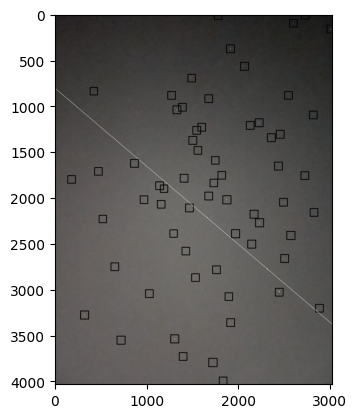

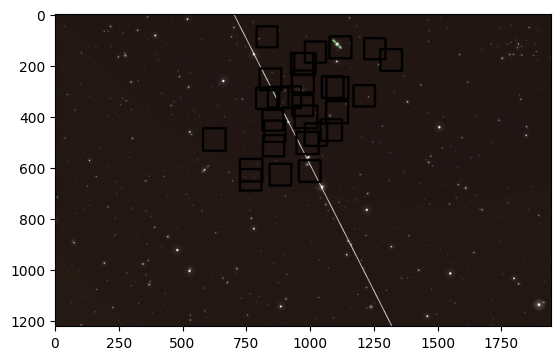

######## Correlation ########
(1391, 3730, 4, 192) => (763, 647, 4, 192)
(1298, 3536, 8, 250) => (763, 607, 8, 250)
(1908, 3360, 5, 210) => (879, 626, 5, 210)
(317, 3276, 8, 253) => (619, 487, 8, 253)
(2436, 3029, 5, 178) => (993, 612, 5, 178)
(1526, 2871, 3, 170) => (853, 514, 3, 170)
(1421, 2582, 3, 241) => (858, 457, 3, 241)
(2136, 2504, 7, 246) => (984, 501, 7, 246)
(1289, 2392, 1, 163) => (851, 415, 1, 163)
(2221, 2271, 8, 249) => (1016, 468, 8, 249)
(2483, 2049, 4, 216) => (1078, 452, 4, 216)
(966, 2022, 3, 149) => (826, 328, 3, 149)
(1865, 2020, 9, 249) => (977, 398, 9, 249)
(1185, 1903, 1, 196) => (872, 325, 1, 196)
(1726, 1840, 2, 164) => (968, 357, 2, 164)
(1401, 1787, 5, 240) => (917, 323, 5, 240)
(2428, 1654, 6, 250) => (1100, 381, 6, 250)
(861, 1625, 5, 251) => (840, 253, 5, 251)
(1496, 1374, 6, 255) => (966, 261, 6, 255)
(2120, 1211, 5, 231) => (1083, 283, 5, 231)
(2217, 1182, 6, 232) => (1101, 286, 6, 232)
(2807, 1098, 4, 199) => (1207, 318, 4, 199)
(1323, 1041, 6, 254) 

In [10]:
# Load the image
img1 = cv.imread('/content/drive/MyDrive/Vision/fr2.jpg')
img2 = cv.imread('/content/drive/MyDrive/Vision/ST_db1.png')

orig_img1 = img1
orig_img2 = img2

rect1 = initial_detection(img1)
rect2 = initial_detection(img2)

draw_rectangles(img1, s_points, (0,0,0))


# Keep img1 to be the small one
if (len(rect1) > len(rect2)):
  tmp = img1
  img1 = img2
  img2 = tmp
  tmp = rect1
  rect1 = rect2
  rect2 = tmp

# Find the lines using RANSAC
lines1, line_points1, top_three1 = ransac_line_fit(rect1)
lines2, line_points2, top_three2 = ransac_line_fit(rect2)

best_diff = 2
for three_points1, c1, (m1, b1) in top_three1:
  for three_points2, c2, (m2, b2) in top_three2:
    curr_diff = similarity(three_points1, three_points2)[0]
    if curr_diff < best_diff:
      best_diff = curr_diff
      best_line = ((m1, b1), (m2, b2))
      best_correlation = (three_points1[:3], three_points2[:3])

m1, b1 = best_line[0]
m2, b2 = best_line[1]

img1 = draw_line(img1, m1, b1)
img2 = draw_line(img2, m2, b2)

s, R, t = compute_transformation(best_correlation)

transformed_points = []

# Detection
img1 = orig_img1
img2 = orig_img2

s_points = stars_detection(img1)
draw_rectangles(img1, s_points, (0,0,0))

for x, y, r, b in s_points:
  newx, newy = transform(x,y, s, R, t)
  transformed_points.append((int(newx), int(newy), r, b))

draw_rectangles_manually(img2, transformed_points)

plt.imshow(img1), plt.show()
plt.imshow(img2), plt.show()

print("######## Correlation ########")
for i in range(len(transformed_points)):
  print(f"{s_points[i]} => {transformed_points[i]}")


**fr2.jpg, ST_db2.png**




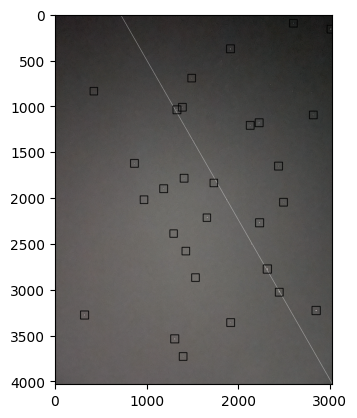

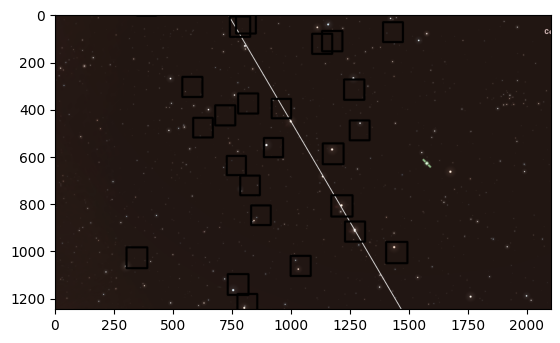

######## Correlation ########
(1391, 3730, 4, 192) => (811, 1222, 4, 192)
(1298, 3536, 8, 250) => (770, 1138, 8, 250)
(1908, 3360, 5, 210) => (1036, 1061, 5, 210)
(317, 3276, 8, 253) => (342, 1025, 8, 253)
(2835, 3226, 10, 250) => (1440, 1002, 10, 250)
(2436, 3029, 5, 178) => (1266, 916, 5, 178)
(1526, 2871, 3, 170) => (869, 848, 3, 170)
(2304, 2774, 10, 247) => (1208, 805, 10, 247)
(1421, 2582, 3, 241) => (823, 722, 3, 241)
(1289, 2392, 1, 163) => (766, 639, 1, 163)
(2221, 2271, 8, 249) => (1172, 586, 8, 249)
(1651, 2219, 1, 165) => (923, 563, 1, 165)
(2483, 2049, 4, 216) => (1286, 489, 4, 216)
(966, 2022, 3, 149) => (624, 478, 3, 149)
(1179, 1901, 5, 247) => (717, 425, 5, 247)
(1726, 1840, 2, 164) => (956, 398, 2, 164)
(1401, 1787, 5, 240) => (814, 375, 5, 240)
(2428, 1654, 6, 250) => (1262, 316, 6, 250)
(861, 1625, 5, 251) => (578, 305, 5, 251)
(2120, 1211, 5, 231) => (1127, 123, 5, 231)
(2217, 1182, 6, 232) => (1169, 111, 6, 232)
(2807, 1098, 4, 199) => (1427, 74, 4, 199)
(1323, 10

In [11]:
# Load the image
img1 = cv.imread('/content/drive/MyDrive/Vision/fr2.jpg')
img2 = cv.imread('/content/drive/MyDrive/Vision/ST_db2.png')

orig_img1 = img1
orig_img2 = img2

rect1 = initial_detection(img1)
rect2 = initial_detection(img2)

# Keep img1 to be the small one
if (len(rect1) > len(rect2)):
  tmp = img1
  img1 = img2
  img2 = tmp
  tmp = rect1
  rect1 = rect2
  rect2 = tmp

# Find the lines using RANSAC
lines1, line_points1, top_three1 = ransac_line_fit(rect1)
lines2, line_points2, top_three2 = ransac_line_fit(rect2)

best_diff = 2
for three_points1, c1, (m1, b1) in top_three1:
  for three_points2, c2, (m2, b2) in top_three2:
    curr_diff = similarity(three_points1, three_points2)[0]
    if curr_diff < best_diff:
      best_diff = curr_diff
      best_line = ((m1, b1), (m2, b2))
      best_correlation = (three_points1[:3], three_points2[:3])

m1, b1 = best_line[0]
m2, b2 = best_line[1]

img1 = draw_line(img1, m1, b1)
img2 = draw_line(img2, m2, b2)

s, R, t = compute_transformation(best_correlation)

transformed_points = []

# Detection
img1 = orig_img1
img2 = orig_img2

s_points = stars_detection(img1)
draw_rectangles(img1, s_points, (0,0,0))

for x, y, r, b in s_points:
  newx, newy = transform(x,y, s, R, t)
  transformed_points.append((int(newx), int(newy), r, b))

draw_rectangles_manually(img2, transformed_points)

plt.imshow(img1), plt.show()
plt.imshow(img2), plt.show()

print("######## Correlation ########")
for i in range(len(transformed_points)):
  print(f"{s_points[i]} => {transformed_points[i]}")

**ST_db1.png, ST_db2.png**

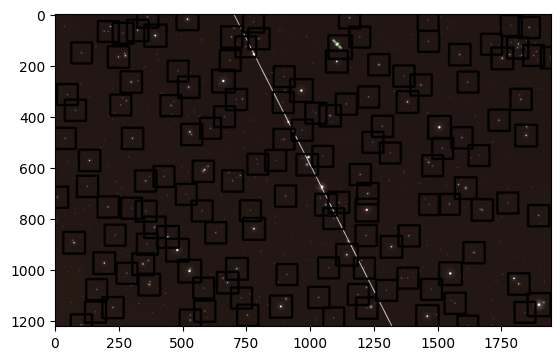

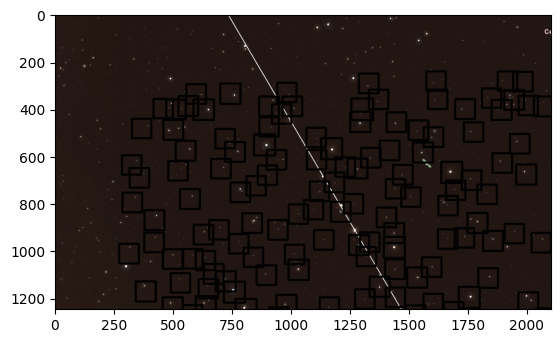

######## Correlation ########
(1614, 1221, 1, 202) => (1826, 1380, 1, 202)
(101, 1216, 3, 240) => (427, 1466, 3, 240)
(527, 1197, 3, 227) => (820, 1423, 3, 227)
(1089, 1189, 2, 187) => (1339, 1382, 2, 187)
(1453, 1180, 7, 255) => (1675, 1352, 7, 255)
(752, 1178, 3, 217) => (1027, 1392, 3, 217)
(1837, 1167, 2, 172) => (2029, 1317, 2, 172)
(157, 1166, 2, 158) => (476, 1417, 2, 158)
(584, 1162, 3, 194) => (870, 1388, 3, 194)
(1218, 1150, 3, 188) => (1456, 1339, 3, 188)
(225, 1148, 3, 253) => (537, 1396, 3, 253)
(880, 1142, 7, 255) => (1143, 1351, 7, 255)
(1888, 1133, 10, 255) => (2074, 1283, 10, 255)
(1563, 1131, 3, 203) => (1774, 1300, 3, 203)
(728, 1111, 2, 184) => (1000, 1332, 2, 184)
(1030, 1108, 3, 223) => (1279, 1311, 3, 223)
(1185, 1097, 2, 202) => (1422, 1292, 2, 202)
(1296, 1081, 2, 193) => (1524, 1270, 2, 193)
(162, 1078, 2, 255) => (475, 1335, 2, 255)
(1471, 1077, 2, 179) => (1685, 1256, 2, 179)
(580, 1072, 2, 184) => (861, 1305, 2, 184)
(366, 1057, 5, 255) => (662, 1304, 5, 25

In [12]:
# Load the image
img1 = cv.imread('/content/drive/MyDrive/Vision/ST_db1.png')
img2 = cv.imread('/content/drive/MyDrive/Vision/ST_db2.png')

orig_img1 = img1
orig_img2 = img2

rect1 = initial_detection(img1)
rect2 = initial_detection(img2)

# Keep img1 to be the small one
if (len(rect1) > len(rect2)):
  tmp = img1
  img1 = img2
  img2 = tmp
  tmp = rect1
  rect1 = rect2
  rect2 = tmp

# Find the lines using RANSAC
lines1, line_points1, top_three1 = ransac_line_fit(rect1)
lines2, line_points2, top_three2 = ransac_line_fit(rect2)

best_diff = 2
for three_points1, c1, (m1, b1) in top_three1:
  for three_points2, c2, (m2, b2) in top_three2:
    curr_diff = similarity(three_points1, three_points2)[0]
    if curr_diff < best_diff:
      best_diff = curr_diff
      best_line = ((m1, b1), (m2, b2))
      best_correlation = (three_points1[:3], three_points2[:3])

m1, b1 = best_line[0]
m2, b2 = best_line[1]

img1 = draw_line(img1, m1, b1)
img2 = draw_line(img2, m2, b2)

s, R, t = compute_transformation(best_correlation)

transformed_points = []

# Detection
img1 = orig_img1
img2 = orig_img2

s_points = stars_detection(img1)
draw_rectangles(img1, s_points, (0,0,0))

for x, y, r, b in s_points:
  newx, newy = transform(x,y, s, R, t)
  transformed_points.append((int(newx), int(newy), r, b))

draw_rectangles_manually(img2, transformed_points)

plt.imshow(img1), plt.show()
plt.imshow(img2), plt.show()

print("######## Correlation ########")
for i in range(len(transformed_points)):
  print(f"{s_points[i]} => {transformed_points[i]}")

**fr1.jpg, fr2.jpg**

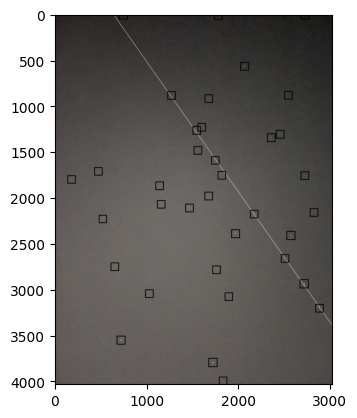

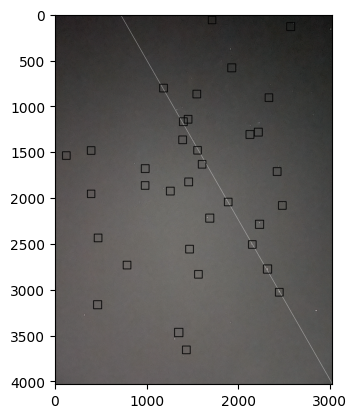

######## Correlation ########
(1826, 3996, 4, 215) => (1426, 3658, 4, 215)
(1712, 3792, 11, 252) => (1340, 3465, 11, 252)
(714, 3550, 8, 254) => (459, 3164, 8, 254)
(2874, 3204, 4, 176) => (2437, 3030, 4, 176)
(1889, 3078, 3, 181) => (1558, 2835, 3, 181)
(1024, 3045, 4, 168) => (781, 2734, 4, 168)
(2705, 2935, 10, 243) => (2306, 2774, 10, 243)
(1754, 2785, 4, 242) => (1461, 2560, 4, 242)
(648, 2752, 4, 212) => (466, 2438, 4, 212)
(2561, 2409, 9, 247) => (2220, 2287, 9, 247)
(1960, 2390, 8, 254) => (1679, 2220, 8, 254)
(519, 2233, 1, 164) => (392, 1959, 1, 164)
(2815, 2160, 4, 219) => (2470, 2084, 4, 219)
(1460, 2111, 5, 251) => (1251, 1927, 5, 251)
(1153, 2072, 3, 168) => (978, 1867, 3, 168)
(1669, 1981, 5, 250) => (1451, 1827, 5, 250)
(1135, 1869, 5, 239) => (978, 1682, 5, 239)
(178, 1801, 3, 203) => (121, 1541, 3, 203)
(2715, 1759, 5, 224) => (2413, 1714, 5, 224)
(1812, 1756, 3, 182) => (1598, 1636, 3, 182)
(470, 1713, 3, 172) => (391, 1486, 3, 172)
(1742, 1594, 2, 168) => (1549, 148

In [13]:
# Load the image
img1 = cv.imread('/content/drive/MyDrive/Vision/fr1.jpg')
img2 = cv.imread('/content/drive/MyDrive/Vision/fr2.jpg')

orig_img1 = img1
orig_img2 = img2

rect1 = initial_detection(img1)
rect2 = initial_detection(img2)

# Keep img1 to be the small one
if (len(rect1) > len(rect2)):
  tmp = img1
  img1 = img2
  img2 = tmp
  tmp = rect1
  rect1 = rect2
  rect2 = tmp

# Find the lines using RANSAC
lines1, line_points1, top_three1 = ransac_line_fit(rect1)
lines2, line_points2, top_three2 = ransac_line_fit(rect2)

best_diff = 2
for three_points1, c1, (m1, b1) in top_three1:
  for three_points2, c2, (m2, b2) in top_three2:
    curr_diff = similarity(three_points1, three_points2)[0]
    if curr_diff < best_diff:
      best_diff = curr_diff
      best_line = ((m1, b1), (m2, b2))
      best_correlation = (three_points1[:3], three_points2[:3])

m1, b1 = best_line[0]
m2, b2 = best_line[1]

img1 = draw_line(img1, m1, b1)
img2 = draw_line(img2, m2, b2)

s, R, t = compute_transformation(best_correlation)

transformed_points = []

# Detection
img1 = orig_img1
img2 = orig_img2

s_points = stars_detection(img1)
draw_rectangles(img1, s_points, (0,0,0))

for x, y, r, b in s_points:
  newx, newy = transform(x,y, s, R, t)
  transformed_points.append((int(newx), int(newy), r, b))

draw_rectangles_manually(img2, transformed_points)

plt.imshow(img1), plt.show()
plt.imshow(img2), plt.show()

print("######## Correlation ########")
for i in range(len(transformed_points)):
  print(f"{s_points[i]} => {transformed_points[i]}")